In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [7]:
MAT_FOLDER = "/content/drive/MyDrive/Pred_maintainance/raw"

In [14]:
def detect_label(fname):
    fname = fname.upper()
    if fname.startswith("B"): return "Ball"
    if fname.startswith("IR"): return "Inner"
    if fname.startswith("OR"): return "Outer"
    if "NORMAL" in fname: return "Normal"
    return None

def load_de_signal(path):
    data = loadmat(path)
    keys = [k for k in data.keys() if not k.startswith("__")]
    for k in keys:
        if "DE" in k.upper():
            return np.ravel(data[k])
    return np.ravel(data[keys[0]])

def extract_features(x):
    rms = np.sqrt(np.mean(x**2))
    return {
        "mean": np.mean(x),
        "std": np.std(x),
        "rms": rms,
        "min": np.min(x),
        "max": np.max(x),
        "ptp": np.ptp(x),
        "skew": skew(x),
        "kurt": kurtosis(x),
        "energy": np.sum(x**2),
        "crest": np.max(np.abs(x)) / (rms + 1e-6)
    }

WINDOW = 2048
STEP = 1024

In [15]:
rows = []

for fname in os.listdir(MAT_FOLDER):
    if not fname.endswith(".mat"):
        continue
    label = detect_label(fname)
    path = os.path.join(MAT_FOLDER, fname)
    sig = load_de_signal(path)
    N = len(sig)
    i = 0
    while i + WINDOW <= N:
        w = sig[i:i+WINDOW]
        feats = extract_features(w)
        feats["label"] = label
        rows.append(feats)
        i += STEP

In [16]:
df = pd.DataFrame(rows)

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)

In [18]:
print("Accuracy:", acc * 100)
print(classification_report(y_test, pred))

Accuracy: 96.62090813093981
              precision    recall  f1-score   support

        Ball       0.95      0.94      0.95       284
       Inner       0.99      1.00      1.00       284
      Normal       1.00      1.00      1.00        94
       Outer       0.94      0.95      0.95       285

    accuracy                           0.97       947
   macro avg       0.97      0.97      0.97       947
weighted avg       0.97      0.97      0.97       947



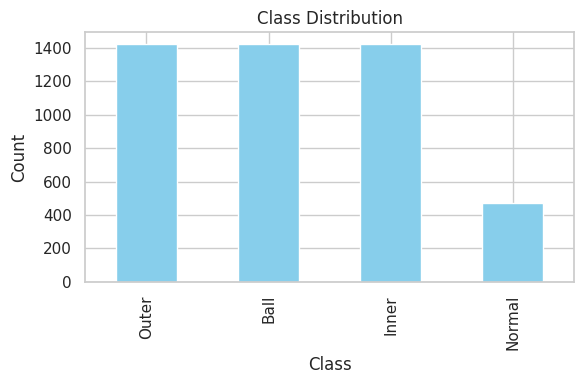

In [19]:
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300)
plt.show()

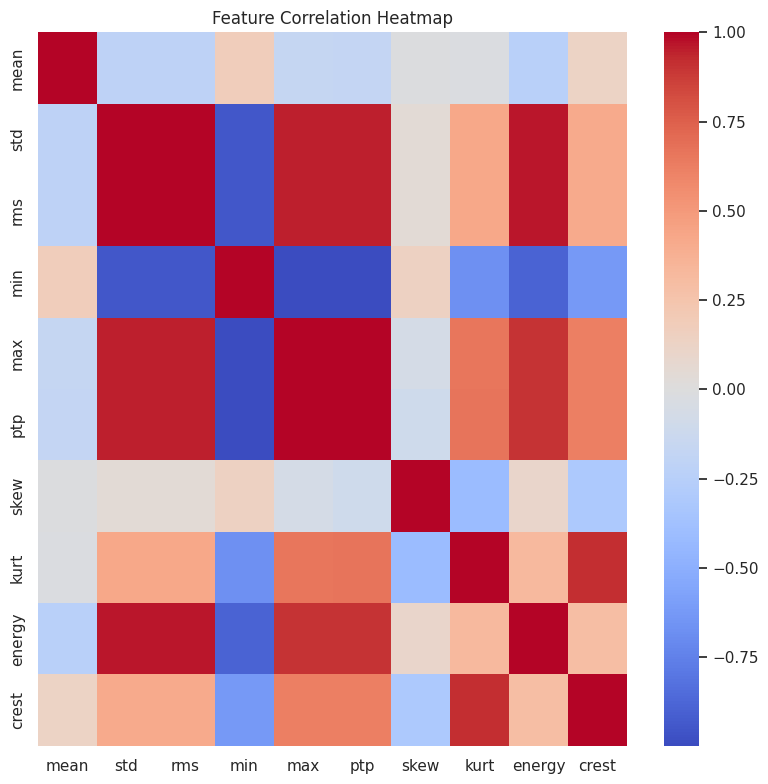

In [21]:
plt.figure(figsize=(8,8))
corr = df.drop(columns=['label']).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()

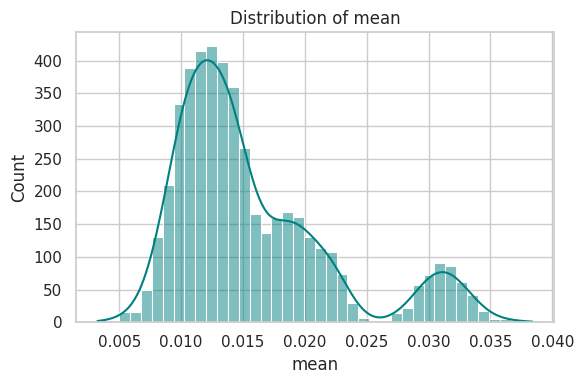

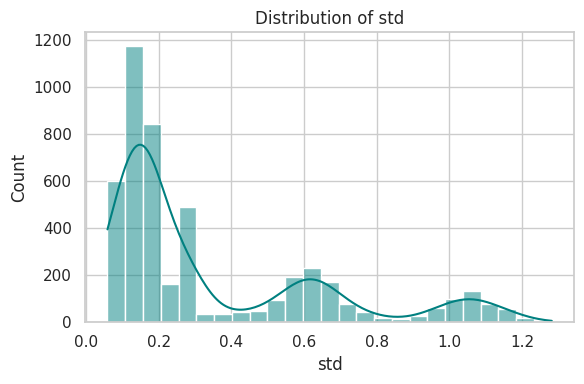

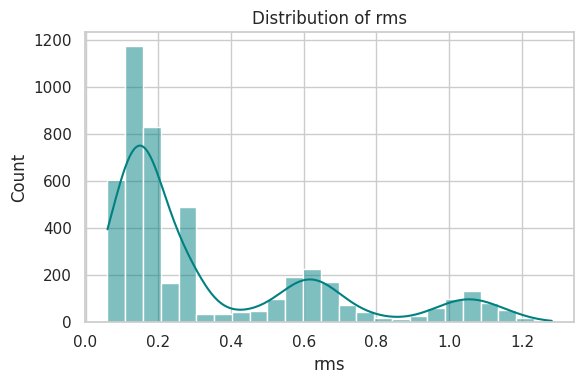

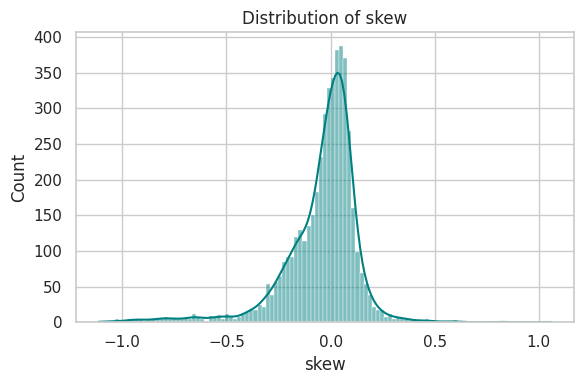

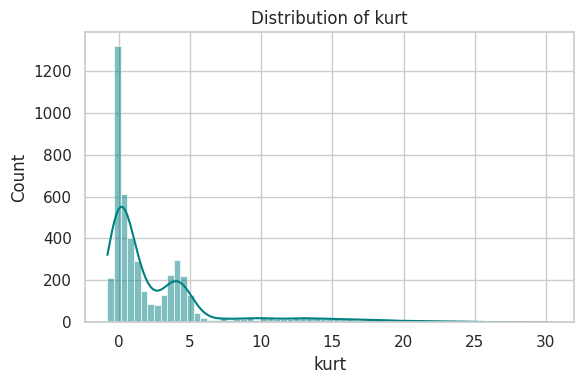

In [22]:
hist_cols = ['mean','std','rms','skew','kurt']

for col in hist_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig(f"hist_{col}.png", dpi=300)
    plt.show()

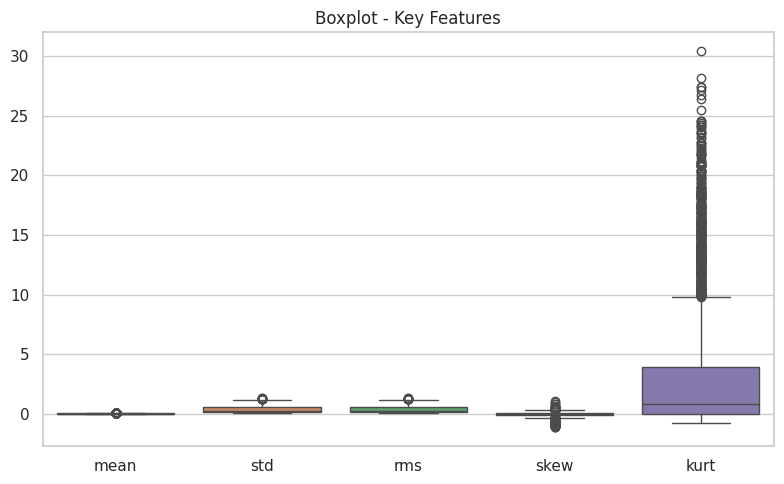

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['mean','std','rms','skew','kurt']])
plt.title('Boxplot - Key Features')
plt.tight_layout()
plt.savefig("boxplot_features.png", dpi=300)
plt.show()


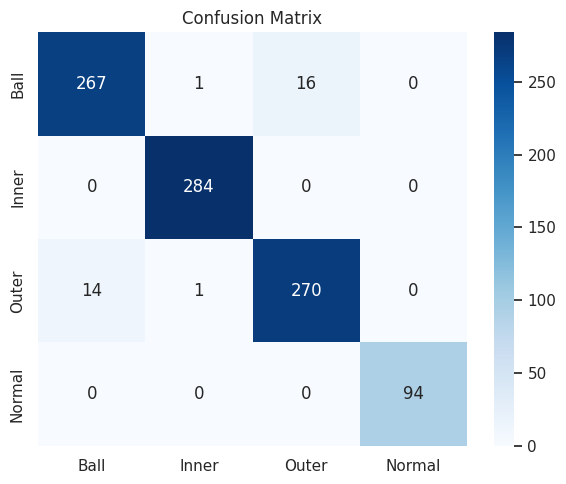

In [25]:
cm = confusion_matrix(y_test, pred, labels=['Ball','Inner','Outer','Normal'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ball','Inner','Outer','Normal'],
            yticklabels=['Ball','Inner','Outer','Normal'])
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

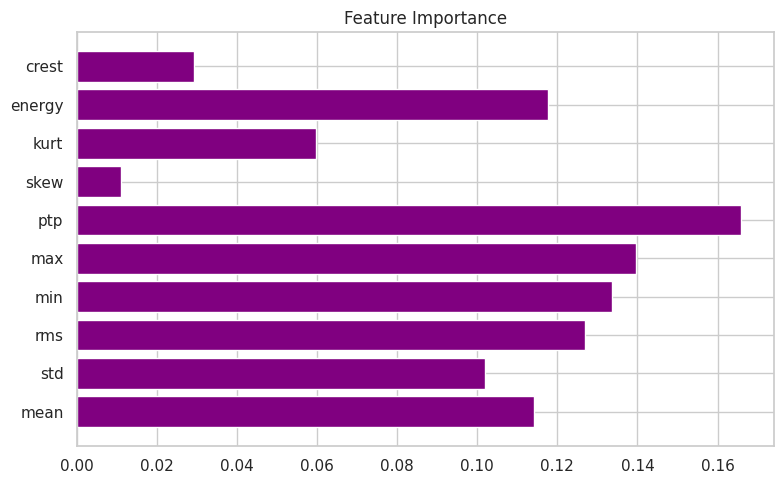

In [26]:
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(X.columns, importances, color='purple')
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()